In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy as sc
import inspect
import copy
from scipy.linalg import expm
import qutip as qt
from functools import reduce
import itertools
import seaborn
from numpy import exp

## Defining qutrit operators

P0 = qt.basis(3,0)*qt.basis(3,0).dag()
P1 = qt.basis(3,1)*qt.basis(3,1).dag()
P2 = qt.basis(3,2)*qt.basis(3,2).dag()

Id = qt.Qobj(np.eye(3))

import sys
sys.path.append('/home/qnl')

import time

from importlib import reload

from qnl_analysis import SimTools as ST

## $T_1$ decay of a qutrit

For $T_1$ decay, the operators we need are $C_0$ and $C_1$ below, essentially the qutrit analogues of the qubit $\sigma_-$ lowering operator

In [4]:
gamma1GE = 1./(10e-6) # 1/s
gamma1EF = 1./(5e-6) # 1/s

C0 = np.sqrt(gamma1GE)*qt.Qobj(np.array([[0,1,0],
                                         [0,0,0],
                                         [0,0,0]]))
C1 = np.sqrt(gamma1EF)*qt.Qobj(np.array([[0,0,0],
                                         [0,0,1],
                                         [0,0,0]]))

times = np.linspace(0,30e-6,50)

In [5]:
H = qt.Qobj(0*np.eye(3))

psi0 = qt.Qobj(np.array([[0, 0, 0],
                        [0, 0.5, 0.5],
                        [0, 0.5, 0.5]]))

result = qt.mesolve(H, psi0, times, [C0, C1],[])

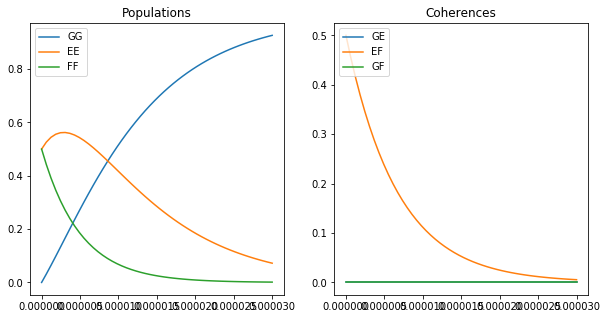

In [6]:
plt.figure(figsize = (10,5))
plt.subplot(121)
plt.plot(result.times, np.real([a[0,0] for a in result.states]), label = 'GG')
plt.plot(result.times, np.real([a[1,1] for a in result.states]), label = 'EE')
plt.plot(result.times, np.real([a[2,2] for a in result.states]), label = 'FF')
plt.title("Populations")
plt.legend(loc = 2)

plt.subplot(122)
plt.plot(result.times, np.abs([a[0,1] for a in result.states]), label = 'GE')
plt.plot(result.times, np.abs([a[1,2] for a in result.states]), label = 'EF')
plt.plot(result.times, np.real([a[0,2] for a in result.states]), label = 'GF')
plt.title("Coherences")
plt.legend(loc = 2)


## $T_1$ and $T_2$ decay of a qutrit

For qutrit $T_2$ decay, we introduce the operators $D_0$ and $D_1$ below, which are analogues of the $\sigma_z$ operator in a qubit

In [7]:
gamma1GE = 1./(100000e-6) # 1/s
gamma1EF = 1./(5e-6) # 1/s

C0 = np.sqrt(gamma1GE)*qt.Qobj(np.array([[0,1,0],[0,0,0],[0,0,0]]))
C1 = np.sqrt(gamma1EF)*qt.Qobj(np.array([[0,0,0],[0,0,1],[0,0,0]]))

In [8]:
gammaphiGE = 1/(100000e-6) # 1/s
gammaphiEF = 1/(100000e-6) # 1/s

D0 = np.sqrt(gammaphiGE) * qt.Qobj(np.diag([1,-1,0]))
D1 = np.sqrt(gammaphiEF) * qt.Qobj(np.diag([0,1,-1]))

In [9]:
psi0 = qt.Qobj(np.array([[0.5, 0, 0.5],
                        [0, 0, 0.5],
                        [0.5, 0, 0.5]]))

In [10]:
result = qt.mesolve(H, psi0, times, [C0, C1, D0, D1], [])

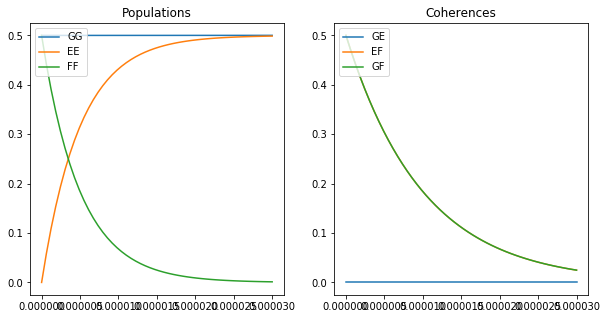

In [11]:
plt.figure(figsize = (10,5))
plt.subplot(121)
plt.plot(result.times, np.real([a[0,0] for a in result.states]), label = 'GG')
plt.plot(result.times, np.real([a[1,1] for a in result.states]), label = 'EE')
plt.plot(result.times, np.real([a[2,2] for a in result.states]), label = 'FF')
plt.title("Populations")
plt.legend(loc = 2)

plt.subplot(122)
plt.plot(result.times, np.abs([a[0,1] for a in result.states]), label = 'GE')
plt.plot(result.times, np.abs([a[1,2] for a in result.states]), label = 'EF')
plt.plot(result.times, np.real([a[0,2] for a in result.states]), label = 'GF')
plt.title("Coherences")
plt.legend(loc = 2)


## ZZ-CSUM with the original (4 EF pi pulses) method

We first define the entangling ZZ Hamiltonian between our qutrits

In [12]:
alpha_11 = 2 * np.pi * -0.27935*1e6 # Hz
alpha_12 = 2 * np.pi * 0.1599*1e6 # Hz
alpha_21 = 2 * np.pi * -0.52793*1e6 # Hz
alpha_22 = 2 * np.pi * -0.742967*1e6 # Hz

H_ZZ = qt.Qobj(np.diag([0,0,0,0,alpha_11, alpha_12, 0, alpha_21, alpha_22]), dims = [[3,3],[3,3]])

We next calculate the required times for these to be turned into a CSUM

In [20]:
T1 = 0.614 * 1e-6 #s
T2 = 0.105 * 1e-6 #s
T3 = 0.614 * 1e-6 #s
T4 = 0.105 * 1e-6 #s

The CSUM gate uses some single-qutrit unitaries, which we define below. In particular, we use the Hadamard gate and $\pi$-pulses on the $|E\rangle\leftrightarrow |F\rangle$ subspace of each qutrit.

In [21]:
omega = np.exp(2*np.pi*1j/3)
omega_inv = np.exp(-2*np.pi*1j/3)
Hadamard = qt.Qobj(1/np.sqrt(3)*np.array([[1,1,1],
                                         [1, omega, omega_inv],
                                         [1, omega_inv, omega]]))
PiEF = qt.Qobj(np.array([[1,0,0],
                        [0,0,-1j],
                        [0,-1j,0]]))

PiEFm = qt.Qobj(np.array([[1,0,0],
                        [0,0,1j],
                        [0,1j,0]]))

In [22]:
Hadamard_Q1 = qt.tensor(Id, Hadamard)
Hadamard_Q1_dag = Hadamard_Q1.dag()

PiEF_Q0 = qt.tensor(PiEF, Id)
PiEF_Q0_dag = PiEF_Q0.dag()

PiEFm_Q0 = qt.tensor(PiEFm, Id)
PiEFm_Q0_dag = PiEFm_Q0.dag()

PiEF_Q1 = qt.tensor(Id, PiEF)
PiEF_Q1_dag = PiEF_Q1.dag()

PiEFm_Q1 = qt.tensor(Id,PiEFm)
PiEFm_Q1_dag = PiEFm_Q1.dag()


In [23]:
def fidelity_of_csum():
    
    gamma1GE_0 = 1./(40e-6) # 1/s
    gamma1EF_0 = 1./(26e-6) # 1/s

    C0 = np.sqrt(gamma1GE_0)*qt.tensor(qt.Qobj(np.array([[0,1,0],[0,0,0],[0,0,0]])), Id)
    C1 = np.sqrt(gamma1EF_0)*qt.tensor(qt.Qobj(np.array([[0,0,0],[0,0,1],[0,0,0]])), Id)

    gammaphiGE_0 = 1/(50e-6) # 1/s
    gammaphiEF_0 = 1/(45e-6) # 1/s

    D0 = np.sqrt(gammaphiGE_0) * qt.tensor(qt.Qobj(np.diag([1,-1,-1])), Id)
    D1 = np.sqrt(gammaphiEF_0) * qt.tensor(qt.Qobj(np.diag([-1,1,-1])), Id)

    gamma1GE_1 = 1./(50e-6) # 1/s
    gamma1EF_1 = 1./(33e-6) # 1/s

    E0 = np.sqrt(gamma1GE_1)*qt.tensor(Id, qt.Qobj(np.array([[0,1,0],[0,0,0],[0,0,0]])))
    E1 = np.sqrt(gamma1EF_1)*qt.tensor(Id, qt.Qobj(np.array([[0,0,0],[0,0,1],[0,0,0]])))

    gammaphiGE_1 = 1/(60e-6) # 1/s
    gammaphiEF_1 = 1/(35e-6) # 1/s

    F0 = np.sqrt(gammaphiGE_1) * qt.tensor(Id, qt.Qobj(np.diag([1,-1,-1])))
    F1 = np.sqrt(gammaphiEF_1) * qt.tensor(Id, qt.Qobj(np.diag([-1,1,-1])))
    
    fidelities = []
    
    for state_0 in range(3):
        for state_1 in range(3):
            state = [state_0, state_1]
            
            psi0 = qt.tensor(qt.basis(3,state[0])*qt.basis(3,state[0]).dag(),qt.basis(3,state[1])*qt.basis(3,state[1]).dag())

            # now do the CSUM
            psi0 = Hadamard_Q1_dag*psi0*Hadamard_Q1

            result = qt.mesolve(H_ZZ, psi0, np.linspace(0,T1,100), [C0, C1, D0, D1, E0, E1, F0, F1], [])
            psi0 = result.states[-1]

            psi0 = PiEF_Q0*psi0*PiEF_Q0_dag

            result = qt.mesolve(H_ZZ, psi0, np.linspace(0,T2,100), [C0, C1, D0, D1, E0, E1, F0, F1], [])
            psi0 = result.states[-1]

            psi0 = PiEF_Q1*psi0*PiEF_Q1_dag

            result = qt.mesolve(H_ZZ, psi0, np.linspace(0,T3,100), [C0, C1, D0, D1, E0, E1, F0, F1], [])

            psi0 = result.states[-1]
            psi0 = PiEFm_Q0*psi0*PiEFm_Q0_dag

            result = qt.mesolve(H_ZZ, psi0, np.linspace(0,T4,100), [C0, C1, D0, D1, E0, E1, F0, F1], [])

            psi0 = result.states[-1]
            psi0 = PiEFm_Q1*psi0*PiEFm_Q1_dag

            psi0 = Hadamard_Q1*psi0*Hadamard_Q1_dag

            fidelities.append(np.abs(psi0[3* state_0 + ((state_0 + state_1)%3), 3* state_0 + ((state_0 + state_1)%3)]))
    
    return fidelities

In [2]:
fidelity_of_csum()

NameError: name 'fidelity_of_csum' is not defined

In [25]:
np.mean(fidelity_of_csum())

0.9025060315655272

## ZZ-CSUM with the shortest time 

We first define the entangling ZZ Hamiltonian between our qutrits

In [3]:
alpha_11 = 2 * np.pi * -0.27935 * 1e6 # Hz
alpha_12 = 2 * np.pi * 0.1599 * 1e6 # Hz
alpha_21 = 2 * np.pi * -0.52793 * 1e6 # Hz
alpha_22 = 2 * np.pi * -0.742967 * 1e6 # Hz

H_ZZ = qt.Qobj(np.diag([0,0,0,0,alpha_11, alpha_12, 0, alpha_21, alpha_22]), dims = [[3,3],[3,3]])

We next calculate the required times for these to be turned into a CSUM

In [4]:
T1 = 0.3986566 * 1e-6 #s
T2 = 0.3986566 * 1e-6  #s
T3 = 0.13608932 * 1e-6 #s
T4 = 0.13608932 * 1e-6 #s

The CSUM gate uses some single-qutrit unitaries, which we define below. In particular, we use the Hadamard gate and $\pi$-pulses on the $|E\rangle\leftrightarrow |F\rangle$ subspace of each qutrit.

In [91]:
omega = np.exp(2*np.pi*1j/3)
omega_inv = np.exp(-2*np.pi*1j/3)
Hadamard = 1/np.sqrt(3)*np.array([[1,1,1],
                                         [1, omega, omega_inv],
                                         [1, omega_inv, omega]])
PiEF = np.array([[1,0,0],
                [0,0,-1j],
                [0,-1j,0]])

PiEFm = np.array([[1,0,0],
                [0,0,1j],
                [0,1j,0]])

PiGE = np.array([[0,-1j,0],
                [-1j,0,0],
                [0,0,1]])

PiGEm = np.array([[0,1j,0],
                [1j,0,0],
                [0,0,1]])

Id = np.eye(3)

In [12]:
PiEF_Q0 = np.kron(PiEF, Id)

PiEFm_Q0 = np.kron(PiEFm, Id)

PiEF_Q1 = np.kron(Id, PiEF)

PiEFm_Q1 = np.kron(Id,PiEFm)

PiGE_Q0 = np.kron(PiGE, Id)

PiGEm_Q0 = np.kron(PiGEm, Id)

PiGE_Q1 = np.kron(Id, PiGE)

PiGEm_Q1 = np.kron(Id,PiGEm)

H_ZZ = np.diag([0,0,0,0,alpha_11, alpha_12, 0, alpha_21, alpha_22])

In [13]:
## single-qutrit permutation matrices
P = {'P0': np.array([[1,0,0],
                     [0,1,0],
                     [0,0,1]]),
     'P1': np.array([[1,0,0],
                     [0,0,1],
                     [0,1,0]]),
     'P2': np.array([[0,1,0],
                     [1,0,0],
                     [0,0,1]]),
     'P3': np.array([[0,1,0],
                     [0,0,1],
                     [1,0,0]]),
     'P4': np.array([[0,0,1],
                     [1,0,0],
                     [0,1,0]]),
     'P5': np.array([[0,0,1],
                     [0,1,0],
                     [1,0,0]]),
    }

In [87]:
np.dot(P['P0'].T,P['P3'])

array([[0, 1, 0],
       [0, 0, 1],
       [1, 0, 0]])

In [100]:
reduce(np.dot, reversed([PiGE, PiEF, PiGE, PiEF, PiEF, PiGE, PiEF, PiGE]))

array([[-1.+0.j,  0.+0.j,  0.+0.j],
       [ 0.+0.j, -1.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j,  1.+0.j]])

In [65]:
PiEF

array([[1, 0, 0],
       [0, 0, 1],
       [0, 1, 0]])

In [47]:
CSUM_permutation_1 = np.dot(np.kron(P['P1'].T,P['P4'].T), np.kron(P['P0'], P['P0']))
CSUM_permutation_2 = np.dot(np.kron(P['P4'].T,P['P5'].T), np.kron(P['P1'], P['P4']))
CSUM_permutation_3 = np.dot(np.kron(P['P5'].T,P['P3'].T), np.kron(P['P4'], P['P5']))
CSUM_permutation_4 = np.dot(np.kron(P['P3'].T,P['P2'].T), np.kron(P['P5'], P['P3']))
CSUM_permutation_5 = np.dot(np.kron(P['P0'].T,P['P0'].T), np.kron(P['P3'], P['P2']))

Phi_00 = -1*(alpha_22 * T2 + alpha_11 * T3 + alpha_21 * T4)
Phi_01 = -1*(alpha_21 * T2 + alpha_22 * T3)
Phi_02 = -1*(alpha_12 * T4)
Phi_10 = -1*(alpha_22 * T1 + alpha_11 * T3 + alpha_21 * T4)
Phi_20 = -1*(alpha_12 * T1 + alpha_12 * T2)

Z_corr = np.kron(expm(-1j*np.diag([0,Phi_10 - Phi_00, Phi_20 - Phi_00])),
                   expm(-1j*np.diag([0,Phi_01 - Phi_00, Phi_02 - Phi_00])))

In [15]:
Hadamard_Q1 = np.kron(Id, Hadamard)
Hadamard_Q1_dag = np.conj(Hadamard_Q1.T)

Hadamard_Q0 = np.kron(Hadamard, Id)
Hadamard_Q0_dag = np.conj(Hadamard_Q0.T)

Hadamard_Q0_map = unitary_op_to_map(Hadamard_Q0)
Hadamard_Q0_dag_map = unitary_op_to_map(Hadamard_Q0_dag)

Hadamard_Q1_map = unitary_op_to_map(Hadamard_Q1)
Hadamard_Q1_dag_map = unitary_op_to_map(Hadamard_Q1_dag)

Z_corr_map = unitary_op_to_map(Z_corr)

Perm1_map = unitary_op_to_map(CSUM_permutation_1)
Perm2_map = unitary_op_to_map(CSUM_permutation_2)
Perm3_map = unitary_op_to_map(CSUM_permutation_3)
Perm4_map = unitary_op_to_map(CSUM_permutation_4)
Perm5_map = unitary_op_to_map(CSUM_permutation_5)

In [16]:
idling_map_T1 = sc.linalg.expm(idling_Lindbladian*T1)
idling_map_T2 = sc.linalg.expm(idling_Lindbladian*T2)
idling_map_T3 = sc.linalg.expm(idling_Lindbladian*T3)
idling_map_T4 = sc.linalg.expm(idling_Lindbladian*T4)

NameError: name 'idling_Lindbladian' is not defined

In [378]:
real_CSUMp1_map = reduce(np.dot, [Hadamard_Q1_map, Z_corr_map, Perm5_map, idling_map_T4, Perm4_map, idling_map_T3, Perm3_map, idling_map_T2, Perm2_map, idling_map_T1, Perm1_map, Hadamard_Q1_dag_map])

In [421]:
init_state = (2,2)
psi_init = [0,0,0,0,0,0,0,0,0]
psi_init[3*init_state[0] + init_state[1]] = 1

rho_init = ST.vec_to_dm(psi_init)
rho_init_vec = rho_init.T.reshape(rho_init.shape[0]*rho_init.shape[1],-1)

rho_final_vec = np.dot(real_CSUMp1_map, rho_init_vec)

rho_final = rho_final_vec.reshape(9,9).T

In [422]:
rho_init

array([[0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1]])

In [423]:
np.round(np.abs(rho_final),3)

array([[0.001, 0.   , 0.001, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.001, 0.001, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.001, 0.001, 0.009, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.002, 0.003, 0.001, 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.003, 0.006, 0.002, 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.001, 0.002, 0.001, 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.026, 0.002, 0.007],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.002, 0.929, 0.002],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.007, 0.002, 0.026]])

In [429]:
0.975*0.975*0.975

0.9268593749999999

00: 92.5
01: 92.5
02: 92.5
10: 92.5
11: 92.5
12: 92.5
20: 92.9
21: 92.9
22: 92.9

In [18]:
def test_csum(state_0 = 0, state_1 = 0):
    
    fidelities = []
    
    psi0 = np.array([0,0,0,0,0,0,0,0,0])
    psi0[state_0*3 + state_1] = 1
    
    psi0 = np.dot(np.kron(np.eye(3), np.conj(Hadamard.T)), psi0)
    
    # do the first permutation
    psi0 = reduce(np.dot, [CSUM_permutation_1,  psi0]) 

    psi0 = np.dot(expm(-1j*H_ZZ*T1),psi0)

    psi0 = reduce(np.dot, [CSUM_permutation_2, psi0])

    psi0 = np.dot(expm(-1j*H_ZZ*T2),psi0)

    psi0 = reduce(np.dot, [CSUM_permutation_3, psi0])
 
    psi0 = np.dot(expm(-1j*H_ZZ*T3),psi0)            

    psi0 = reduce(np.dot, [CSUM_permutation_4, psi0])

    psi0 = np.dot(expm(-1j*H_ZZ*T4),psi0)
            
    psi0 = reduce(np.dot, [CSUM_permutation_5, psi0])
   
    Phi_00 = -1*(alpha_22 * T2 + alpha_11 * T3 + alpha_21 * T4)
    Phi_01 = -1*(alpha_21 * T2 + alpha_22 * T3)
    Phi_02 = -1*(alpha_12 * T4)
    Phi_10 = -1*(alpha_22 * T1 + alpha_11 * T3 + alpha_21 * T4)
    Phi_20 = -1*(alpha_12 * T1 + alpha_12 * T2)

    Z_corr = np.kron(expm(-1j*np.diag([0,Phi_10 - Phi_00, Phi_20 - Phi_00])),
                       expm(-1j*np.diag([0,Phi_01 - Phi_00, Phi_02 - Phi_00])))
    
    psi0 = reduce(np.dot, [Z_corr, psi0])
    psi0 = psi0*exp(-1j*Phi_00)
    
    psi0 = np.dot(np.kron(np.eye(3), Hadamard), psi0)
    
    print(np.abs(psi0))

    return psi0

In [105]:
expm(-1j*np.diag([0,Phi_01 - Phi_00, Phi_02 - Phi_00]))

array([[ 1.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ],
       [ 0.        +0.j        ,  0.82891884+0.55936889j,
         0.        +0.j        ],
       [-0.        +0.j        , -0.        +0.j        ,
        -0.89888709+0.43818032j]])

In [107]:
np.angle(-0.89888709+0.43818032j)*180/np.pi - np.angle(0.82891884+0.55936889j)*180/np.pi

120.00000044742617

In [20]:
test_csum(0,0);

[1.00000000e+00 2.49800181e-16 1.94289029e-16 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00]


## Direct calculation of the two-qutrit quantum map

To simulate the performance of the ZZ-based CSUM gate in the scrambling algorithm, we extract here the quantum map by directly (numerically) exponentiating the Lindbladian.  We'll compare this with the results obtained by solving the master equation above.  This calculation does not rely on QuTiP and thus serves as an independent check of the dynamics.

Following [this paper](https://arxiv.org/pdf/1510.08634.pdf), if we vectorize the density matrix by simply ordering the columns one below the other, so that the $(a,b)$ entry of $\rho$ is the $(bn + a)$$^{th}$ entry (zero-indexed) of the vector $\vec{r}$, and if we write the master equation in standard form as 

\begin{equation}
\frac { d } { d t } \hat { \boldsymbol { \rho } } ( t ) = \mathcal { L } \hat { \boldsymbol { \rho } } = -  i   [ \hat { \mathbf { H } } , \hat { \boldsymbol { \rho } } ] + \sum _ { i } \gamma _ { i } \left( \hat { \mathbf { A } } _ { i } \hat { \boldsymbol { \rho } } \hat { \mathbf { A } } _ { i } ^ { \dagger } - \frac { 1 } { 2 } \left\{ \hat { \mathbf { A } } _ { i } ^ { \dagger } \hat { \mathbf { A } } _ { i } , \hat { \boldsymbol { \rho } } \right\} \right)
\end{equation},

then the vectorized versions of the operators are:

\begin{equation}
[ \hat { \mathbf { H } } , \hat { \boldsymbol { \rho } } ] \rightarrow  \left( I \otimes \hat { \mathbf { H } } - \hat { \mathbf { H } } ^ { T } \otimes I \right) \vec { r }
\end{equation}

\begin{equation}
\hat { \mathbf { A } } _ { i } \hat { \boldsymbol { \rho } } \hat { \mathbf { A } } _ { i } ^ { \dagger } \rightarrow \left( \left( \hat { \mathbf { A } } _ { i } ^ { \dagger } \right) ^ { T } \otimes \hat { \mathbf { A } } _ { i } \right) \vec { r }
\end{equation}

\begin{equation}
\hat { \mathbf { A } } _ { i } ^ { \dagger } \mathbf { \hat { A } } _ { i } \hat { \boldsymbol { \rho } } \rightarrow \left( I \otimes \hat { \mathbf { A } } _ { i } ^ { \dagger } \hat { \mathbf { A } } _ { i } \right) \vec { r }
\end{equation}

\begin{equation}
\hat { \boldsymbol { \rho } } \hat { \mathbf { A } } _ { i } ^ { \dagger } \hat { \mathbf { A } } _ { i } \rightarrow \left( \left( \hat { \mathbf { A } } _ { i } ^ { \dagger } \hat { \mathbf { A } } _ { i } \right) ^ { T } \otimes I \right) \vec { r }
\end{equation}

That means the whole Lindbladian can be expressed as:

\begin{equation}
L = -i \left( I \otimes \hat { \mathbf { H } } - \hat { \mathbf { H } } ^ { T } \otimes I \right)+ \sum _ { i } \gamma _ { i } \left( \left( \hat { \mathbf { A } } _ { i } ^ { \dagger } \right) ^ { T } \otimes \hat { \mathbf { A } } _ { i } - \frac { 1 } { 2 } \left( I \otimes \hat { \mathbf { A } } _ { i } ^ { \dagger } \hat { \mathbf { A } } _ { i } + \left( \hat { \mathbf { A } } _ { i } ^ { \dagger } \hat { \mathbf { A } } _ { i } \right) ^ { T } \otimes I \right) \right)
\end{equation}

In terms of which the Master equation becomes:

\begin{equation}
\frac { d } { d t } \vec { r } = L \vec { r }
\end{equation}

*Take a look at the code here for matrix_Lindbladian, a function which implements the above calculations given a Hamiltonian, collapse rates, and collapse operators:*

In [358]:
def matrix_Lindbladian(Hamiltonian, collapse_rates, collapse_operators):
    """
    Forms a Lindbladian superoperator in 'vectorized' form, 
    i.e. a matrix which acts on a 'vectorized' density matrix
    
    Arguments:
    Hamiltonian - an n x n matrix (if the Hilbert space dimension is n) 
                    describing the coherent part of the system's evolution
    collapse_rates - a list of numbers, each of which corresponds to a collapse_operator in 
                    the list collapse_operators.  
    collapse_operators - a list of operators which act as collapse operators in the 
                    master equation describing the evolution
                    
    Returns:
    Lindbladian - an n^2 x n^2 matrix representing the Lindbladian superoperator in vectorized form
                The convention is that this acts on a density matrix which has been vectorized by 
                stacking columns one on top of the other. 
    """
    
    assert len(collapse_rates) == len(collapse_operators)
    
    system_dimension = Hamiltonian.shape
    
    identity_matrix = np.eye(system_dimension[0])
    
    # start by vectorizing the Hamiltonian part of the Lindbladian
    Lindbladian = -1j * (np.kron(identity_matrix, Hamiltonian) - np.kron(Hamiltonian.T, identity_matrix) )
    
    # then add each collapse term, again in vectorized form
    for collapse_index, collapse_rate in enumerate(collapse_rates):
        collapse_operator = collapse_operators[collapse_index]
        
        collapse_term = collapse_rate * (np.kron(np.conj(collapse_operator), collapse_operator) - \
                                        0.5 * np.kron(identity_matrix, np.dot(np.conj(collapse_operator.T), collapse_operator)) - \
                                        0.5 * np.kron(np.dot(np.conj(collapse_operator.T), collapse_operator), identity_matrix))
        
        Lindbladian = Lindbladian + collapse_term
    
    return Lindbladian


In [366]:
Id = np.eye(3)

H_ZZ = np.diag([0,0,0,0,alpha_11, alpha_12, 0, alpha_21, alpha_22])

gamma1GE_0 = 1./(40e-6) # 1/s
gamma1EF_0 = 1./(26e-6) # 1/s

C0 = np.kron(np.array([[0,1,0],[0,0,0],[0,0,0]]), Id)
C1 = np.kron(np.array([[0,0,0],[0,0,1],[0,0,0]]), Id)

gammaphiGE_0 = 1/(50e-6) # 1/s
gammaphiEF_0 = 1/(45e-6) # 1/s

D0 = np.kron(np.diag([1,-1,-1]), Id)
D1 = np.kron(np.diag([-1,1,-1]), Id)

gamma1GE_1 = 1./(50e-6) # 1/s
gamma1EF_1 = 1./(33e-6) # 1/s

E0 = np.kron(Id, np.array([[0,1,0],[0,0,0],[0,0,0]]))
E1 = np.kron(Id, np.array([[0,0,0],[0,0,1],[0,0,0]]))

gammaphiGE_1 = 1/(60e-6) # 1/s
gammaphiEF_1 = 1/(35e-6) # 1/s

F0 = np.kron(Id, np.diag([1,-1,-1]))
F1 = np.kron(Id, np.diag([-1,1,-1]))
    
qutrit_collapse_rates = [gamma1GE_0, gamma1EF_0, gammaphiGE_0, gammaphiEF_0, gamma1GE_1, gamma1EF_1, gammaphiGE_1, gammaphiEF_1]
qutrit_collapse_ops = [C0, C1, D0, D1, E0, E1, F0, F1]

In [367]:
idling_Lindbladian = matrix_Lindbladian(H_ZZ, qutrit_collapse_rates, qutrit_collapse_ops)
nodecay_Lindbladian = matrix_Lindbladian(H_ZZ, [0]*8, qutrit_collapse_ops)

In [394]:
idling_map_T1 = sc.linalg.expm(idling_Lindbladian*T1)
idling_map_T2 = sc.linalg.expm(idling_Lindbladian*T2)
idling_map_T3 = sc.linalg.expm(idling_Lindbladian*T3)
idling_map_T4 = sc.linalg.expm(idling_Lindbladian*T4)

idling_nodecay_map_T1 = sc.linalg.expm(nodecay_Lindbladian*T1)
idling_nodecay_map_T2 = sc.linalg.expm(nodecay_Lindbladian*T2)
idling_nodecay_map_T3 = sc.linalg.expm(nodecay_Lindbladian*T3)
idling_nodecay_map_T4 = sc.linalg.expm(nodecay_Lindbladian*T4)

We also need the vectorized map representations of the unitary operations representing the $\pi$ pulses and the Hadamard gate.  From the considerations above, namely the equation

\begin{equation}
\hat { \mathbf { A } } _ { i } \hat { \boldsymbol { \rho } } \hat { \mathbf { A } } _ { i } ^ { \dagger } \rightarrow \left( \left( \hat { \mathbf { A } } _ { i } ^ { \dagger } \right) ^ { T } \otimes \hat { \mathbf { A } } _ { i } \right) \vec { r }
\end{equation}

we gather that a unitary operation $\hat U$ is represented as $\hat U^* \otimes \hat U$

*This is implemented in ST.unitary_op_to_map(), using the code below*

In [11]:
def unitary_op_to_map(unitary_op):
    """
    Given a unitary operator, converts it into vectorized form.

    that is, the n x n matrix unitary_op is defined such that it transforms density matrices via
    rho_out = unitary_op * rho_in * unitary_op.dagger
    
    The vectorized version is defined such that it acts on the vectorized density matrix rho_in_vec by
    rho_out_vec = vectorized_unitary_op * rho_in_vec

    The vectorized version of a unitary operator is given by np.kron(unitary_op*, unitary_op) 
    [see https://arxiv.org/pdf/1510.08634.pdf (page 4) for a proof]
    """
    return np.kron(np.conj(unitary_op), unitary_op)


In [399]:
omega = np.exp(2*np.pi*1j/3)
omega_inv = np.exp(-2*np.pi*1j/3)
Hadamard = 1/np.sqrt(3)*np.array([[1,1,1],
                                 [1, omega, omega_inv],
                                 [1, omega_inv, omega]])
PiEF = np.array([[1,0,0],
                [0,0,-1j],
                [0,-1j,0]])

PiEFm = np.array([[1,0,0],
                [0,0,1j],
                [0,1j,0]])

Hadamard_Q1 = np.kron(Id, Hadamard)
Hadamard_Q1_dag = np.conj(Hadamard_Q1.T)

Hadamard_Q0 = np.kron(Hadamard, Id)
Hadamard_Q0_dag = np.conj(Hadamard_Q0.T)

PiEF_Q0 = np.kron(PiEF, Id)
PiEFm_Q0 = np.kron(PiEFm, Id)
PiEF_Q1 = np.kron(Id, PiEF)
PiEFm_Q1 = np.kron(Id,PiEFm)

PiEF_Q0_map = ST.unitary_op_to_map(PiEF_Q0)
PiEFm_Q0_map = ST.unitary_op_to_map(PiEFm_Q0)
PiEF_Q1_map = ST.unitary_op_to_map(PiEF_Q1)
PiEFm_Q1_map = ST.unitary_op_to_map(PiEFm_Q1)
Hadamard_Q1_map = ST.unitary_op_to_map(Hadamard_Q1)
Hadamard_Q1_dag_map = ST.unitary_op_to_map(Hadamard_Q1_dag)

Hadamard_Q0_map = ST.unitary_op_to_map(Hadamard_Q0)
Hadamard_Q0_dag_map = ST.unitary_op_to_map(Hadamard_Q0_dag)

In [318]:
real_CSUMp1_map = reduce(np.dot, [Hadamard_Q1_map, PiEFm_Q1_map, idling_map_T4, PiEFm_Q0_map, idling_map_T3, PiEF_Q1_map, idling_map_T2, PiEF_Q0_map, idling_map_T1, Hadamard_Q1_dag_map])
real_CMINp1_map = reduce(np.dot, [Hadamard_Q1_map, PiEFm_Q1_map, idling_map_T3, PiEFm_Q0_map, idling_map_T4, PiEF_Q1_map, idling_map_T1, PiEF_Q0_map, idling_map_T2, Hadamard_Q1_dag_map])

ideal_CSUMp1_map = reduce(np.dot, [Hadamard_Q1_map, PiEFm_Q1_map, idling_nodecay_map_T4, PiEFm_Q0_map, idling_nodecay_map_T3, PiEF_Q1_map, idling_nodecay_map_T2, PiEF_Q0_map, idling_nodecay_map_T1, Hadamard_Q1_dag_map])
ideal_CMINp1_map = reduce(np.dot, [Hadamard_Q1_map, PiEFm_Q1_map, idling_nodecay_map_T3, PiEFm_Q0_map, idling_nodecay_map_T4, PiEF_Q1_map, idling_nodecay_map_T1, PiEF_Q0_map, idling_nodecay_map_T2, Hadamard_Q1_dag_map])

real_CSUMm1_map = reduce(np.dot, [Hadamard_Q0_map, PiEFm_Q1_map, idling_map_T4, PiEFm_Q0_map, idling_map_T3, PiEF_Q1_map, idling_map_T2, PiEF_Q0_map, idling_map_T1, Hadamard_Q0_dag_map])
real_CMINm1_map = reduce(np.dot, [Hadamard_Q0_map, PiEFm_Q1_map, idling_map_T3, PiEFm_Q0_map, idling_map_T4, PiEF_Q1_map, idling_map_T1, PiEF_Q0_map, idling_map_T2, Hadamard_Q0_dag_map])

ideal_CSUMm1_map = reduce(np.dot, [Hadamard_Q0_map, PiEFm_Q1_map, idling_nodecay_map_T4, PiEFm_Q0_map, idling_nodecay_map_T3, PiEF_Q1_map, idling_nodecay_map_T2, PiEF_Q0_map, idling_nodecay_map_T1, Hadamard_Q0_dag_map])
ideal_CMINm1_map = reduce(np.dot, [Hadamard_Q0_map, PiEFm_Q1_map, idling_nodecay_map_T3, PiEFm_Q0_map, idling_nodecay_map_T4, PiEF_Q1_map, idling_nodecay_map_T1, PiEF_Q0_map, idling_nodecay_map_T2, Hadamard_Q0_dag_map])

In [401]:
def Scrambling_map(CSUM_map, CMIN_map, scrambling_param = 1):
    """ 
    When scrambling_param == 1, returns the scrambler.
    When scrambling_param == 0, returns the identity
    
    
    """
    
    TwoQHad_unitary = np.kron(Hadamard_to_identity(scrambling_param), Hadamard_to_identity(scrambling_param))
    TwoQHadDag_unitary = np.conj(TwoQHad_unitary).T
    
    
    TwoQHad_map = unitary_op_to_map(TwoQHad_unitary)
    TwoQHadDag_map = unitary_op_to_map(TwoQHadDag_unitary)
    
    return reduce(np.dot, [TwoQHadDag_map, CMIN_map, TwoQHad_map, CSUM_map])

def Scrambling_star_map(CSUM_map, CMIN_map, scrambling_param = 1):
    """ When scrambling_param == 1, returns the scrambler conjugate.
    When scrambling_param == 0, returns the identity conjugate (which is just the identity)"""
    
    TwoQHadStar_unitary = np.kron(HadamardStar_to_identity(scrambling_param), HadamardStar_to_identity(scrambling_param))
    TwoQHadDagStar_unitary = np.conj(TwoQHadStar_unitary).T
    
    TwoQHadStar_map = unitary_op_to_map(TwoQHadStar_unitary)
    TwoQHadDagStar_map = unitary_op_to_map(TwoQHadDagStar_unitary)
    
    return reduce(np.dot, [TwoQHadDagStar_map, CMIN_map, TwoQHadStar_map, CSUM_map])


In [402]:
ideal_scrambling_map = Scrambling_map(ideal_CSUMp1_map, ideal_CMINp1_map, 1)
real_scrambling_map = Scrambling_map(real_CSUMp1_map, real_CMINp1_map, 1)

ideal_scramblingstar_map = Scrambling_star_map(ideal_CSUMm1_map, ideal_CMINm1_map, 1)
real_scramblingstar_map = Scrambling_star_map(real_CSUMm1_map, real_CMINm1_map, 1)

In [321]:
def Hadamard_to_identity(alpha):
    """ returns a single-qutrit unitary matrix which
    smoothly interpolates between the Hadamard gate and the identity gate
    When alpha is unity, it is the Hadamard
    When alpha is zero, it is the identity
    """
    
    Hadamard_pulse_sequence = [['EFY-90'],
    ['X90'],
    ['Z{:.5f}'.format(-109.471*alpha)],
    ['EFZ{:.5f}'.format(54.7355*alpha)],
    ['X-90'],
    ['Z{:.5f}'.format(180*alpha)],
    ['EFZ{:.5f}'.format(-90*alpha)],
    ['EFY90']]
    
    return resulting_unitary(Hadamard_pulse_sequence)

def HadamardStar_to_identity(alpha):
    """ returns a single-qutrit unitary matrix which
    smoothly interpolates between the Hadamard gate and the identity gate
    When alpha is unity, it is the Hadamard
    When alpha is zero, it is the identity
    """
    
    Hadamard_pulse_sequence = [['EFY-90'],
    ['X-90'],
    ['Z{:.5f}'.format(109.471*alpha)],
    ['EFZ{:.5f}'.format(-54.7355*alpha)],
    ['X90'],
    ['Z{:.5f}'.format(-180*alpha)],
    ['EFZ{:.5f}'.format(90*alpha)],
    ['EFY90']]
    
    return resulting_unitary(Hadamard_pulse_sequence)

In [36]:
from qnl_ctrl.qnl_analysis import SimTools as ST
from qnl_ctrl.qnl_analysis.SimTools import bit_to_trit, rot_x, rot_y, trit_z

def resulting_unitary(pulse_sequence):
    # starting from the initial state, calculates the unitary after the pulse_sequence is applied                                                                            
    # here time flows from left to right, in that the first pulse in the pulse_string is the first pulse applied.
    single_qutrit_unitary = np.eye(3)
    for x in pulse_sequence:
        pulse_string = x[0]
        if pulse_string in list(qutrit_mapping.keys()):
            single_qutrit_unitary = np.dot(qutrit_mapping[pulse_string], single_qutrit_unitary)
        else:
            if pulse_string[0] == 'Z':
                phase = np.pi*float(pulse_string[1:])/180.
                single_qutrit_unitary = np.dot(trit_z(phase,-1)[0], single_qutrit_unitary)

            elif pulse_string[0:3] == 'EFZ':
                phase = np.pi*float(pulse_string[3:])/180.
                single_qutrit_unitary = np.dot(trit_z(phase,1)[0], single_qutrit_unitary)
    return single_qutrit_unitary

qutrit_mapping = {'I': np.eye(3, dtype='complex'),                                                                                                                               
                  'GPrep': np.eye(3, dtype='complex'),
                  'X90': bit_to_trit(rot_x(np.pi/2.)),
                  'X-90': bit_to_trit(rot_x(-np.pi/2.)),
                  'Y90': bit_to_trit(rot_y(np.pi/2.)),
                  'Y-90': bit_to_trit(rot_y(-np.pi/2.)),
                  'X270': bit_to_trit(rot_x(-np.pi/2.)),
                  'Y270': bit_to_trit(rot_y(-np.pi/2.)),
                  'X180': bit_to_trit(rot_x(np.pi)),
                  'Y180': bit_to_trit(rot_y(np.pi)),
                  'EFX90': bit_to_trit(rot_x(np.pi/2.), 1),
                  'EFX-90': bit_to_trit(rot_x(-np.pi/2.), 1),
                  'EFY90': bit_to_trit(rot_y(np.pi/2.), 1),
                  'EFY-90': bit_to_trit(rot_y(-np.pi/2.), 1),
                  'EFX270': bit_to_trit(rot_x(-np.pi/2.), 1),
                  'EFY270': bit_to_trit(rot_y(-np.pi/2.), 1),
                  'EFX180': bit_to_trit(rot_x(np.pi), 1),
                  'EFY180': bit_to_trit(rot_y(np.pi), 1),
                  'Delay': np.eye(3, dtype='complex'),
                  'Hadamard': np.sqrt(1./3)*np.array([[1,1,1],
                                        [1,np.exp(1j*2*np.pi/3),np.exp(-1j*2*np.pi/3)],
                                        [1,np.exp(-1j*2*np.pi/3),np.exp(1j*2*np.pi/3)]]),
                  'R': np.diag([1, np.exp(1j*2*np.pi/3),np.exp(1j*2*np.pi/3)])                   }

## Simulating our algorithm performance

In [367]:
EPR_state = np.array([1,0,0,0,1,0,0,0,1])/np.sqrt(3)

psi0 = reduce(np.kron, [state_to_teleport, EPR_state, EPR_state])
rho0 = ST.vec_to_dm(psi0)

In [368]:
EPR_projector = np.outer(EPR_state, np.conj(EPR_state))
full_EPR_projector = reduce(np.kron, [np.eye(3), EPR_projector, np.eye(9)])

Now we need to combine the maps to get the full five-qutrit quantum map.  Based on the equation below, 

\begin{equation}
\hat { \mathbf { A } } _ { i } \hat { \boldsymbol { \rho } } \hat { \mathbf { A } } _ { i } ^ { \dagger } \rightarrow \left( \left( \hat { \mathbf { A } } _ { i } ^ { \dagger } \right) ^ { T } \otimes \hat { \mathbf { A } } _ { i } \right) \vec { r }
\end{equation}

we can infer that a general superoperator transforms as 
\begin{equation}
\hat { \mathbf { A } }  \hat { \boldsymbol { \rho } } \hat { \mathbf { B } } \rightarrow \left( \left( \hat { \mathbf { B } }  \right) ^ { T } \otimes \hat { \mathbf { A } }\right) \vec { r }
\end{equation}

Unfortunately, as far as I can tell, there is no general way to combine two vectorized maps $\mathcal{L}_1(\rho_1)$ and $\mathcal{L}_2(\rho_2)$ to get vectorized form for the general map $\mathcal{L}_{total}(\rho_1 \otimes \rho_2) \equiv \mathcal{L}_1(\rho_1) \otimes \mathcal{L}_2(\rho_2)$.  But, it is pretty clear that if we have the Kraus representation for both the maps $\mathcal{L}_1$ and $\mathcal{L}_2$, then we can easily convert that to a vectorized superoperator.

So, we have to now take a detour and figure out how to get the Kraus map from a vectorized superoperator.

### Getting a Kraus map from a vectorized superoperator

The answer was given in [this paper](https://aip.scitation.org/doi/abs/10.1063/1.1518555) in 2003.  Basically, one converts from a superoperator $\mathcal{S}$ to the so-called Choi matrix $\mathcal{T}$ via the transformation 

\begin{equation}
\mathcal{T} = \sum_{i,j=0}^{N-1} \left(\mathbb{E}_{ij}\otimes\mathbb{I}\right)\mathcal{S}\left( \mathbb{I}\otimes\mathbb{E}_{ij}\right),
\end{equation}


where $\mathbb{I}$ is the $N$ by $N$ identity matrix (where $N$ is the Hilbert space dimension, e.g. $N=9$ for a two-qutrit system), and $\mathbb{E}_{ij}$ is the $N$ by $N$ matrix with a single element equal to unity (the $i,j$ element).  

In [505]:
print(inspect.getsource(ST.ABsuperop_to_matrix))
print(inspect.getsource(ST.Kraus_ops_to_matrix))
print(inspect.getsource(ST.E))
print(inspect.getsource(ST.choi_matrix))

def ABsuperop_to_matrix(A, B):
    """ given operators A and B, in terms of which the superoperator Sis defined as
    S(rho) = A rho B, this method returns the matrix representation of S"""

    return np.kron(B.T, A)

def Kraus_ops_to_matrix(left_ops, right_ops):
    """given a list of left_ops and right_ops such that
    S(rho) = sum_i leftops[i] rho rightops[i], this method returns the matrix representation of S"""
    
    return np.sum([ABsuperop_to_matrix(left_ops[i], right_ops[i]) for i in range(len(left_ops))],axis = 0)

def E(i,j,N):
    E_matrix = np.zeros((N,N))
    E_matrix[i,j] = 1
    return E_matrix

def choi_matrix(superoperator_matrix):
    """ Returns the Choi matrix corresopnding to the given superoperator-matrix. """
    
    # make sure the superoperator_matrix is square
    assert superoperator_matrix.shape[0] == superoperator_matrix.shape[1]
    
    Hilbert_space_dimension = int(np.floor(np.sqrt(superoperator_matrix.shape[0])))
    assert Hilbert_space_dimensio

Once we have the choi matrix $\mathcal{T}$, we can use the SVD of T, i.e. the decomposition of $\mathcal{T}$ into
\begin{equation}
\mathcal{T} \equiv \mathcal{V}\mathcal{\Omega}\mathcal{W}^\dagger = \sum_{k=0}^{N^2-1} \omega_k \mathbf{v_k}\mathbf{w_k}^\dagger,
\end{equation}
we can write that 
\begin{equation}
\mathcal{S}\mathrm{col}\left( \mathbf{X} \right)  = \mathrm{col} \left( \sum_{k=0}^{N^2-1} \omega_k \mathbf{V_k}\mathbf{X}\mathbf{W_k}^\dagger \right),
\end{equation}
where $\mathrm{col}(\mathbf{V_k}) = \mathbf{v}_k$ and $\mathrm{col}(\mathbf{W_k}) = \mathbf{w}_k$.

This is not exactly the Kraus form, but for our purposes we don't care that much, since we know how to vectorize things in the form above.

In [506]:
print(inspect.getsource(ST.to_Kraus_ops))

def to_Kraus_ops(superoperator_matrix, svd_threshold = 1e-10):    
    """
    Returns the Kraus operators corresponding to the superoperator_matrix
    
    Arguments:
    superoperator_matrix: the matrix representation of the superoperator, in the vectorized basis
    svd_threshold: the threshold value below which singular values are considered to be zero
    
    """
    Hilbert_space_dimension = int(np.floor(np.sqrt(superoperator_matrix.shape[0])))
    assert Hilbert_space_dimension * Hilbert_space_dimension == superoperator_matrix.shape[0]

    
    # first convert the superoperator matrix into a Choi matrix
    choi = choi_matrix(superoperator_matrix)
    
    u, s, v = np.linalg.svd(choi)
    
    #we don't really need u on their own, so we can just take the dot product of u and s
    us = np.dot(u,np.diag(s))
    
    #to get the columns we should take the transpose of v
    vT = v.T 
    
    left_ops = []
    right_ops = []
    for i in range(superoperator_matrix.shape[0]):
 

In [503]:
states = {'GS': np.array([1,0,0]), 'ES': np.array([0,1,0]), 'FS': np.array([0,0,1])}

scrambling_param = 1

teleportation_fidelities_ideal = {}
teleportation_fidelities_real = {}

EPR_state = np.array([1,0,0,0,1,0,0,0,1])/np.sqrt(3)


ideal_scrambling_map = Scrambling_map(ideal_CSUMp1_map, ideal_CMINp1_map, scrambling_param)
real_scrambling_map = Scrambling_map(real_CSUMp1_map, real_CMINp1_map, scrambling_param)

ideal_scramblingstar_map = Scrambling_star_map(ideal_CSUMm1_map, ideal_CMINm1_map, scrambling_param)
real_scramblingstar_map = Scrambling_star_map(real_CSUMm1_map, real_CMINm1_map, scrambling_param)

###
# calculate real evolution
###
l1real, r1real = ST.to_Kraus_ops(real_scrambling_map)
l2real, r2real = ST.to_Kraus_ops(real_scramblingstar_map)

ltotreal, rtotreal = ST.Krauslike_tensor(l1real, r1real, l2real, r2real)
ltotreal, rtotreal = ST.Krauslike_tensor(ltotreal, rtotreal, [np.eye(3)], [np.eye(3)])

###
# calculate ideal evolution
###

l1ideal, r1ideal = ST.to_Kraus_ops(ideal_scrambling_map)
l2ideal, r2ideal = ST.to_Kraus_ops(ideal_scramblingstar_map)

ltotideal, rtotideal = ST.Krauslike_tensor(l1ideal, r1ideal, l2ideal, r2ideal)
ltotideal, rtotideal = ST.Krauslike_tensor(ltotideal, rtotideal, [np.eye(3)], [np.eye(3)])

In [504]:
n_randomizations = 100

fidelities = []

for _ in range(n_randomizations):

    input_state = np.random.randn(3) + 1j*np.random.randn(3)
    input_state = input_state / np.linalg.norm(input_state)

    input_dm = ST.vec_to_dm(input_state)

    psi0 = reduce(np.kron, [input_state, EPR_state, EPR_state])
    rho0 = ST.vec_to_dm(psi0)

    rho_app = np.zeros(rho0.shape)
    for i in range(len(ltotreal)):
        rho_app = rho_app + reduce(np.dot, [ltotreal[i], rho0, rtotreal[i]])

    rho_proj = reduce(np.dot, [full_EPR_projector, rho_app, full_EPR_projector])
    rho_proj = rho_proj / np.trace(rho_proj)

    final_state = ST.partial_trace(rho_proj, k = 0, dim = [[81,81],[3,3]])
    final_state = final_state / np.trace(final_state)

    fid = ST.fidelity(final_state, input_dm)
    fidelities.append(fid)
    print(fid)

0.690707263744
0.6662395752250001
0.696181640625
0.7109272172250001
0.7552444263040001
0.7174784556810001
0.6904446648999999
0.677635190596
0.7319555359359999
0.7092166225


KeyboardInterrupt: 